# Notebook 06: Visualization and Comprehensive Analysis
## Benchmarking SAM & MedSAM Robustness under Noisy Abdominal CT Conditions

**Author:** Hoang Le Chau      
**Date:** January 2026

---

### Objective
Create comprehensive visualizations and analysis for the research study:
1. Performance degradation curves across noise intensities
2. Model comparison heatmaps
3. Failure case analysis and qualitative visualizations
4. Statistical significance testing
5. Publication-ready figures

These visualizations support the quantitative findings and provide interpretable insights.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

print("Libraries imported and style configured")

Libraries imported and style configured


### 1. Mount Drive and Load Results

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/')
OUTPUT_PATH = BASE_PATH / 'SAM_Robustness_Study'
RESULTS_PATH = OUTPUT_PATH / 'results'
PREDICTIONS_PATH = OUTPUT_PATH / 'predictions'
NOISY_DATA_PATH = OUTPUT_PATH / 'noisy_data'
FIGURES_PATH = OUTPUT_PATH / 'figures'
FIGURES_PATH.mkdir(exist_ok=True)

print(f"Results path: {RESULTS_PATH}")
print(f"Figures will be saved to: {FIGURES_PATH}")

Mounted at /content/drive
Results path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/results
Figures will be saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/figures


In [3]:
liver_detailed = pd.read_csv(RESULTS_PATH / 'liver_detailed_metrics.csv')
spleen_detailed = pd.read_csv(RESULTS_PATH / 'spleen_detailed_metrics.csv')
liver_agg = pd.read_csv(RESULTS_PATH / 'liver_aggregate_metrics.csv')
spleen_agg = pd.read_csv(RESULTS_PATH / 'spleen_aggregate_metrics.csv')

print(f"Liver detailed: {liver_detailed.shape}")
print(f"Spleen detailed: {spleen_detailed.shape}")
print(f"Liver aggregate: {liver_agg.shape}")
print(f"Spleen aggregate: {spleen_agg.shape}")

Liver detailed: (1900, 11)
Spleen detailed: (1900, 11)
Liver aggregate: (38, 20)
Spleen aggregate: (38, 20)


### 2. Performance Degradation Curves

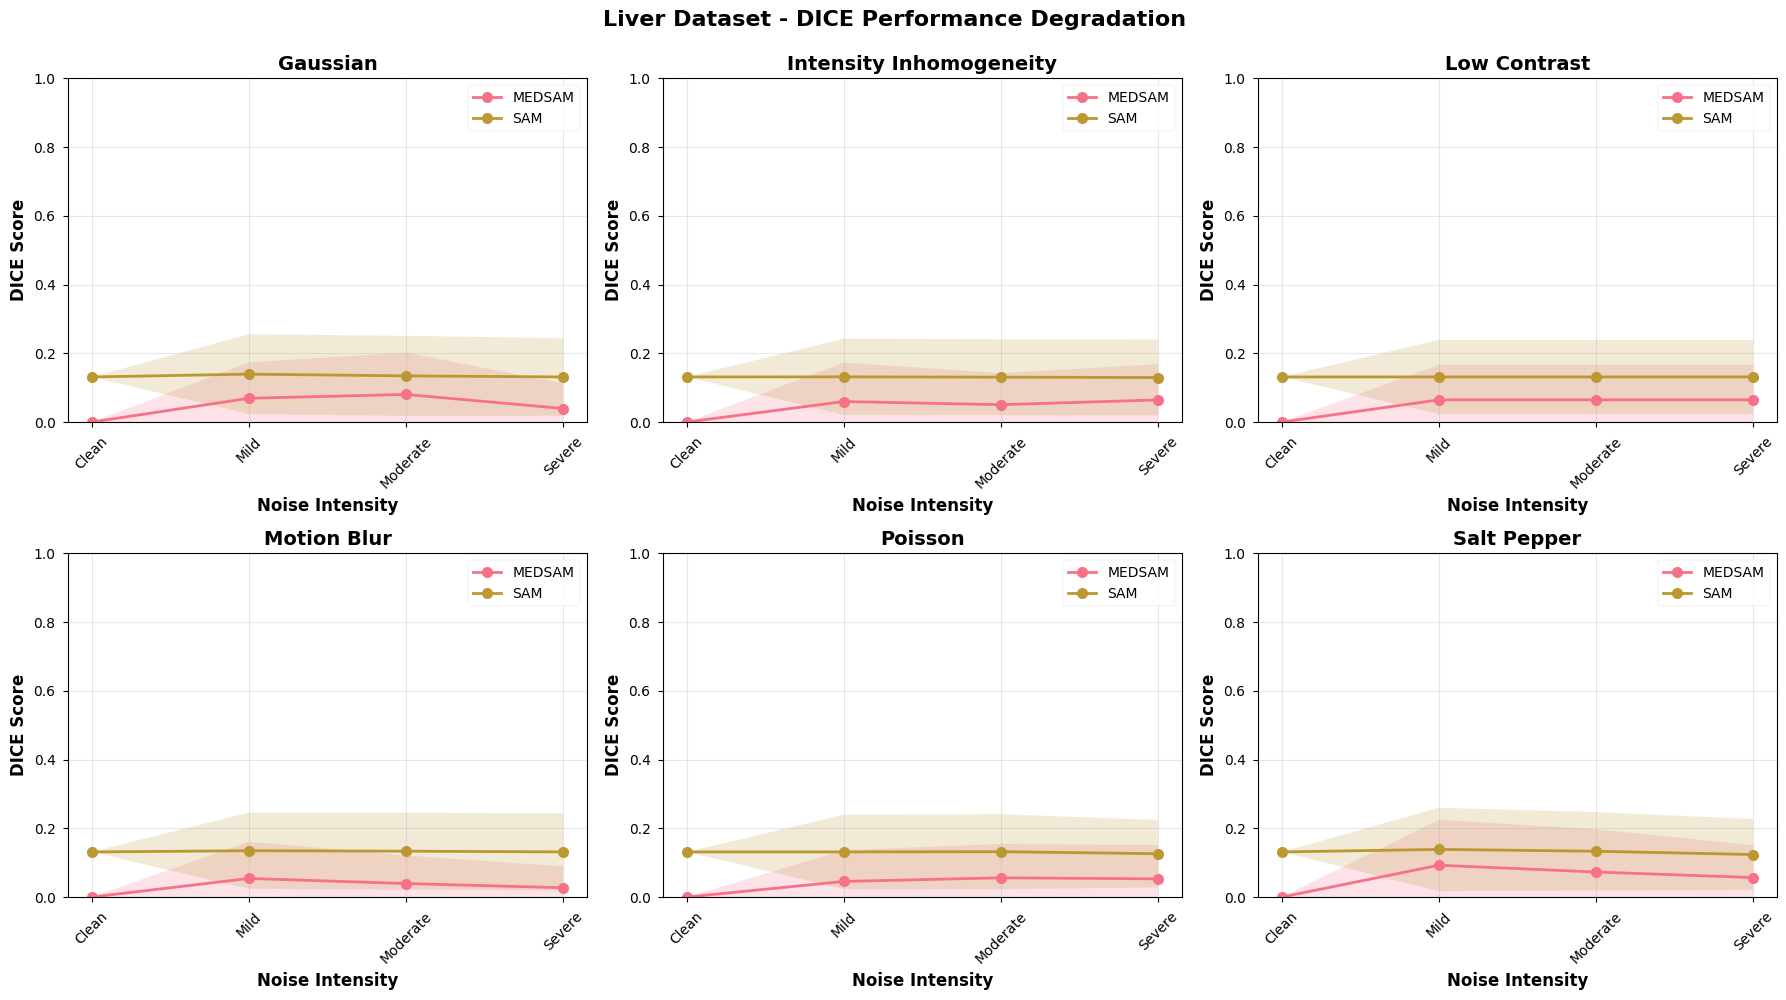

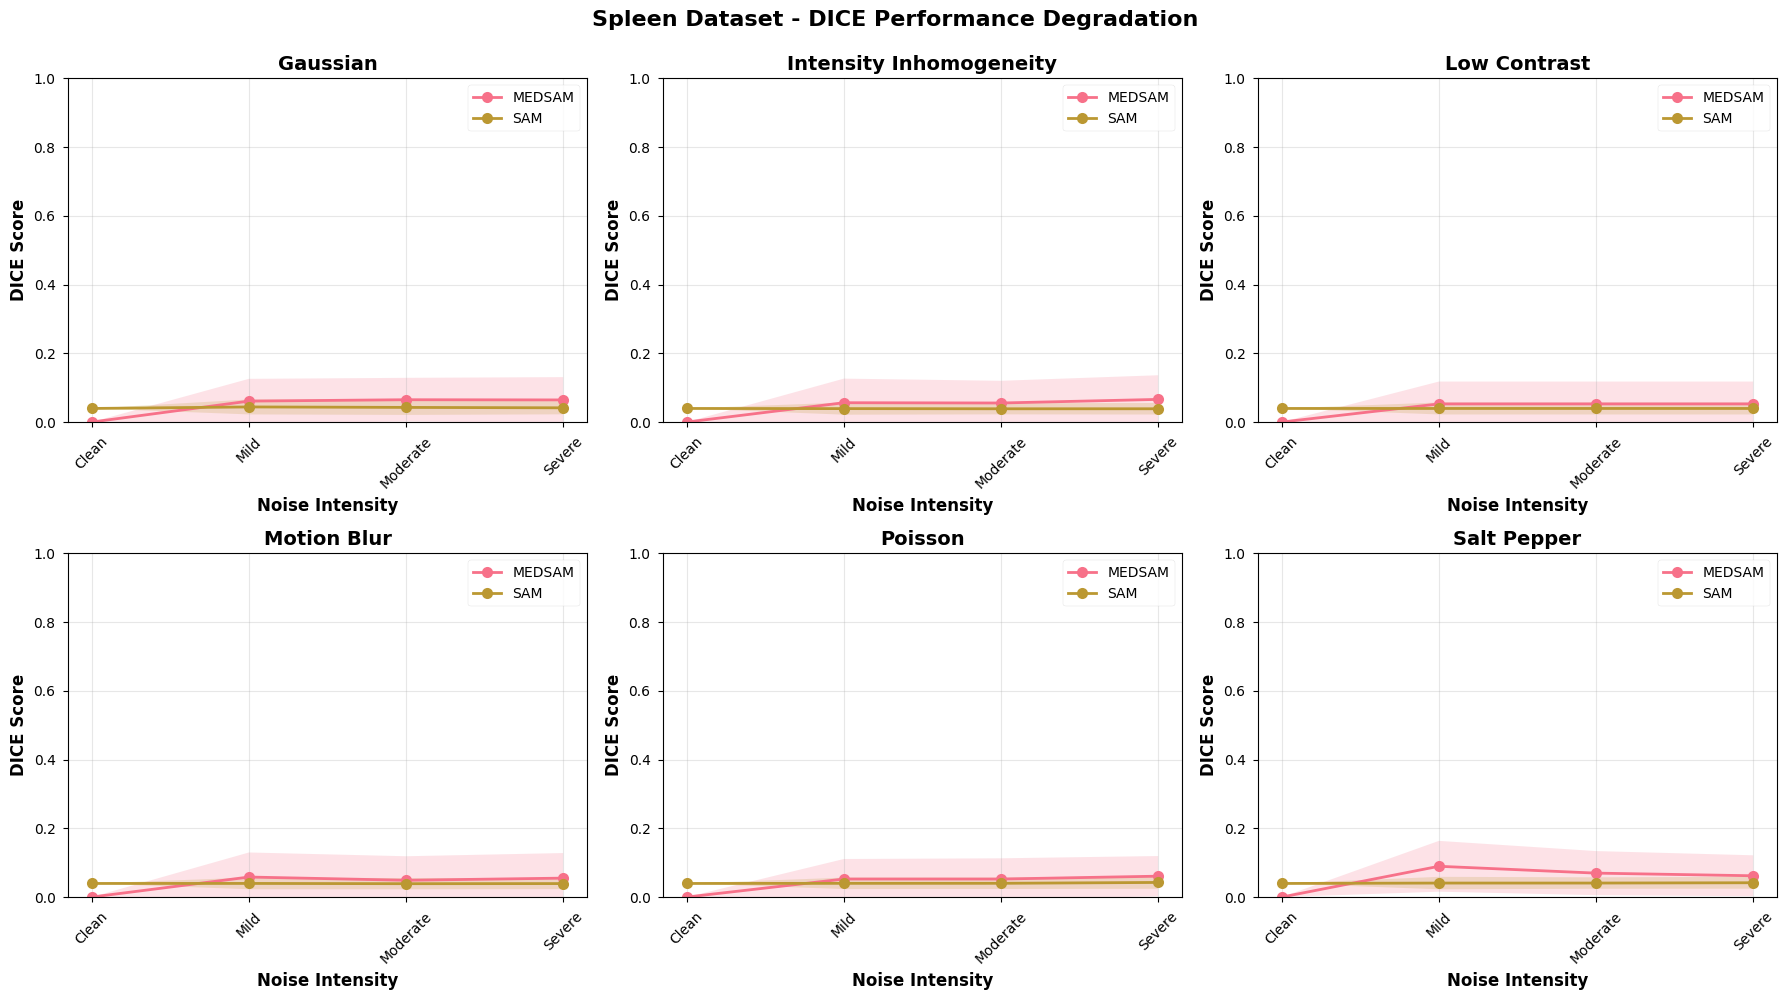

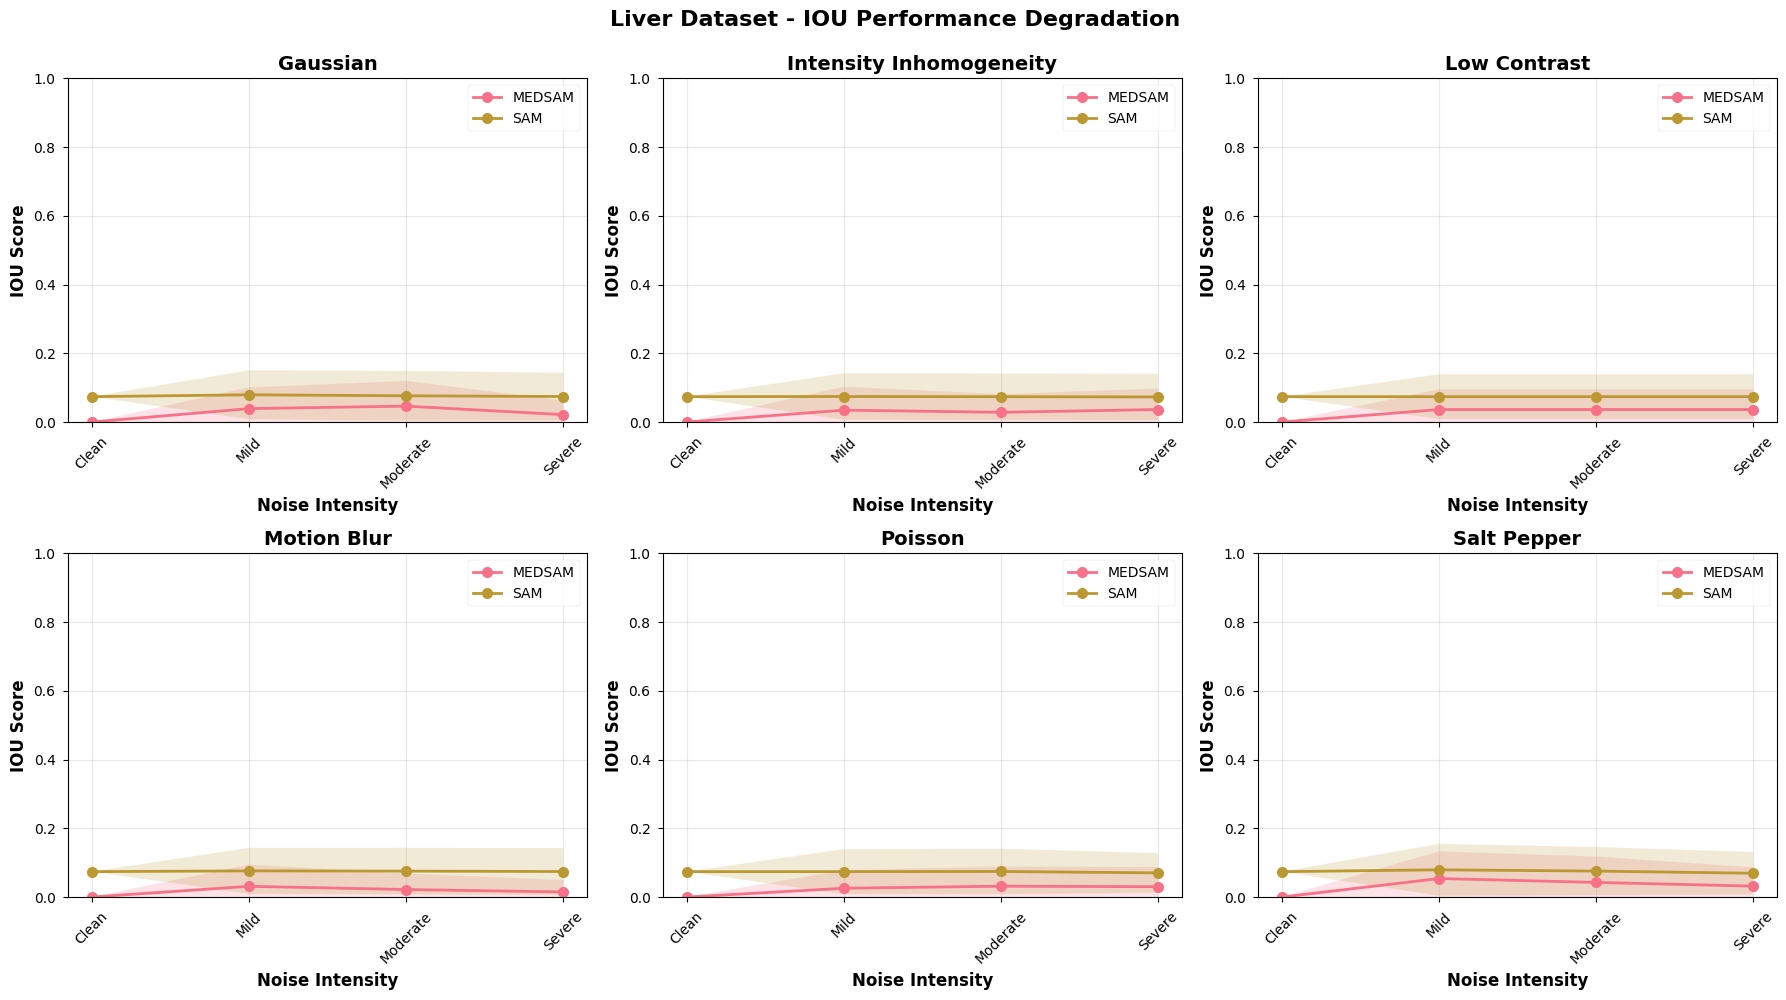

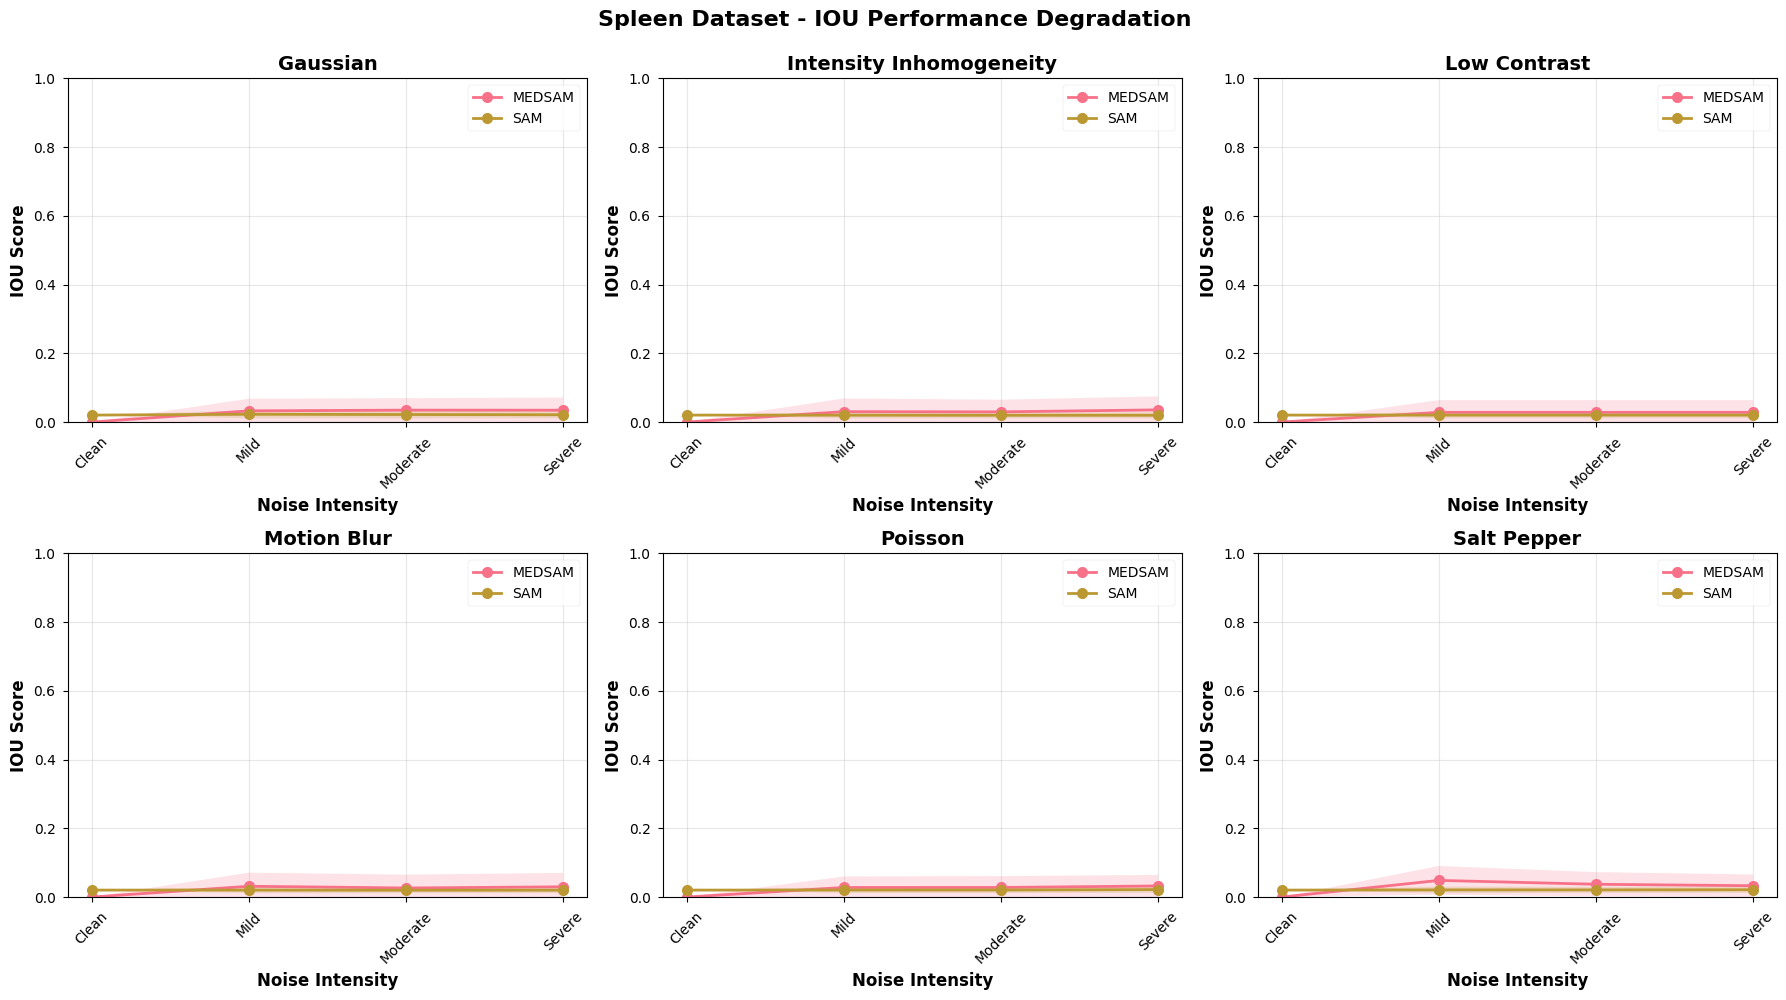

In [4]:
def plot_performance_degradation(agg_df, dataset_name, metric='dice'):
    """
    Plot performance degradation curves across noise intensities.

    Args:
        agg_df: Aggregate metrics DataFrame
        dataset_name: Name of dataset
        metric: Metric to plot
    """
    noise_types = agg_df['noise_type'].unique()
    noise_types = [nt for nt in noise_types if nt != 'clean']

    intensity_order = ['clean', 'mild', 'moderate', 'severe']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, noise_type in enumerate(noise_types):
        ax = axes[idx]

        for model in agg_df['model'].unique():
            clean_data = agg_df[
                (agg_df['model'] == model) &
                (agg_df['intensity'] == 'clean')
            ]
            clean_value = clean_data[f'{metric}_mean'].values[0] if len(clean_data) > 0 else 0

            noise_data = agg_df[
                (agg_df['model'] == model) &
                (agg_df['noise_type'] == noise_type)
            ]

            intensities = ['clean'] + noise_data['intensity'].tolist()
            values = [clean_value] + noise_data[f'{metric}_mean'].tolist()
            stds = [0] + noise_data[f'{metric}_std'].tolist()

            x_pos = [intensity_order.index(i) for i in intensities]

            ax.plot(x_pos, values, marker='o', label=model, linewidth=2, markersize=8)
            ax.fill_between(x_pos,
                          [v - s for v, s in zip(values, stds)],
                          [v + s for v, s in zip(values, stds)],
                          alpha=0.2)

        ax.set_xlabel('Noise Intensity', fontweight='bold')
        ax.set_ylabel(f'{metric.upper()} Score', fontweight='bold')
        ax.set_title(noise_type.replace('_', ' ').title(), fontweight='bold')
        ax.set_xticks(range(len(intensity_order)))
        ax.set_xticklabels([i.capitalize() for i in intensity_order], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.0])

    if len(noise_types) < 6:
        for idx in range(len(noise_types), 6):
            fig.delaxes(axes[idx])

    plt.suptitle(f'{dataset_name.capitalize()} Dataset - {metric.upper()} Performance Degradation',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_{metric}_degradation.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_performance_degradation(liver_agg, 'liver', metric='dice')
plot_performance_degradation(spleen_agg, 'spleen', metric='dice')
plot_performance_degradation(liver_agg, 'liver', metric='iou')
plot_performance_degradation(spleen_agg, 'spleen', metric='iou')

### 3. Model Comparison Heatmaps

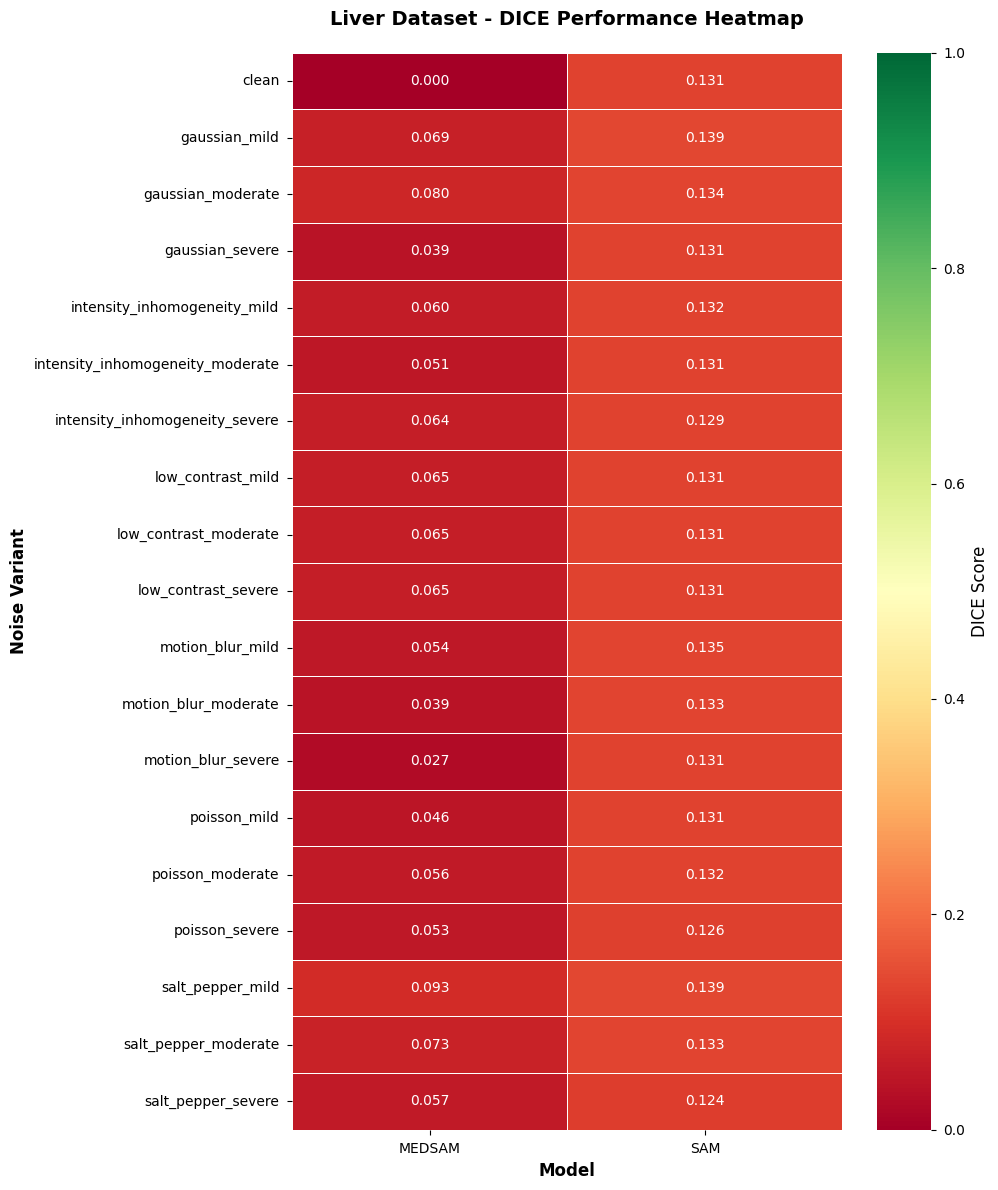

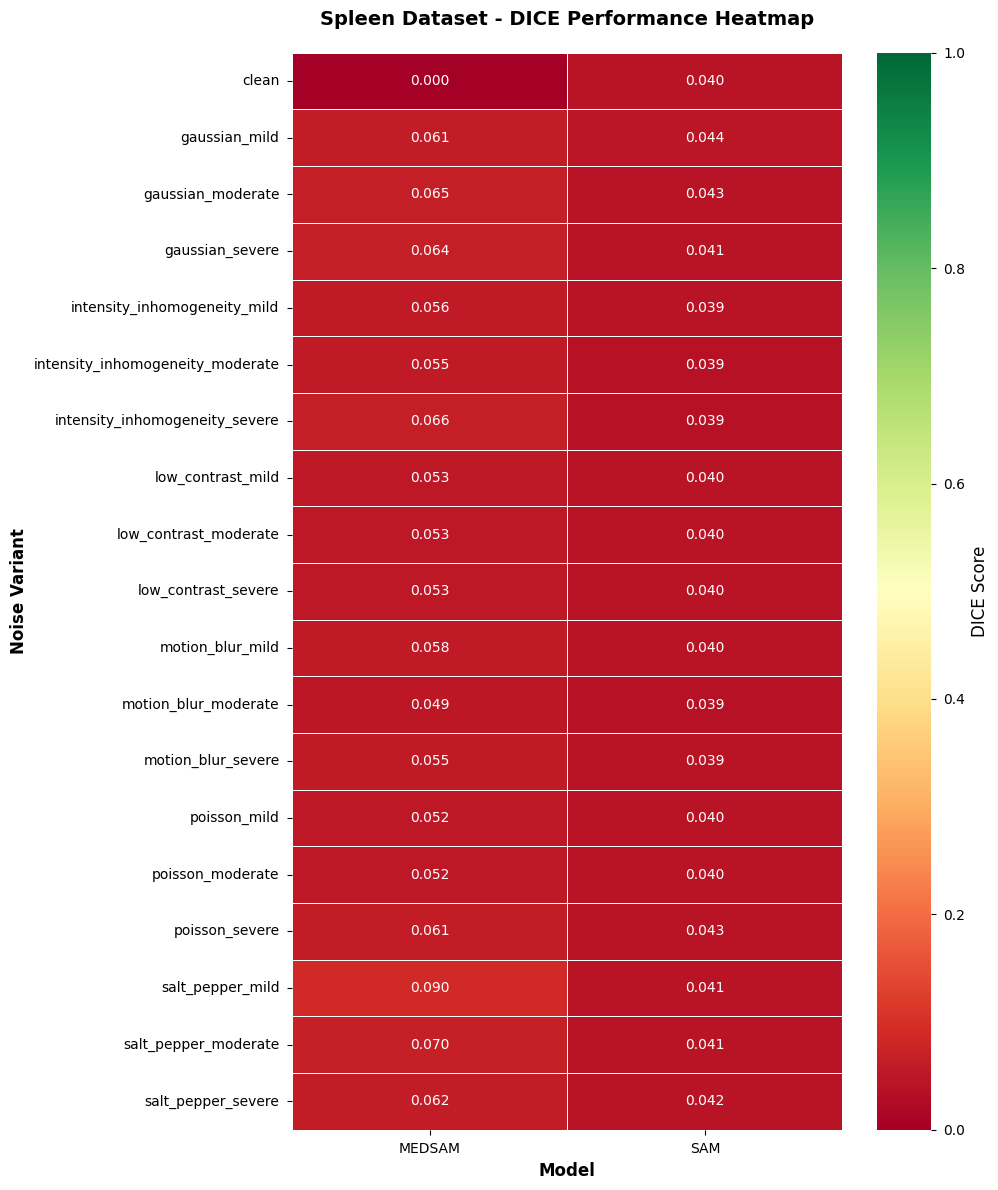

In [5]:
def plot_comparison_heatmap(agg_df, dataset_name, metric='dice'):
    """
    Create heatmap comparing models across noise variants.

    Args:
        agg_df: Aggregate metrics DataFrame
        dataset_name: Name of dataset
        metric: Metric to visualize
    """
    pivot_data = agg_df.pivot_table(
        values=f'{metric}_mean',
        index='variant',
        columns='model',
        aggfunc='mean'
    )

    fig, ax = plt.subplots(figsize=(10, 12))

    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': f'{metric.upper()} Score'},
                vmin=0, vmax=1.0, linewidths=0.5, ax=ax)

    ax.set_xlabel('Model', fontweight='bold')
    ax.set_ylabel('Noise Variant', fontweight='bold')
    ax.set_title(f'{dataset_name.capitalize()} Dataset - {metric.upper()} Performance Heatmap',
                fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_{metric}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_comparison_heatmap(liver_agg, 'liver', metric='dice')
plot_comparison_heatmap(spleen_agg, 'spleen', metric='dice')

### 4. Box Plots for Metric Distribution

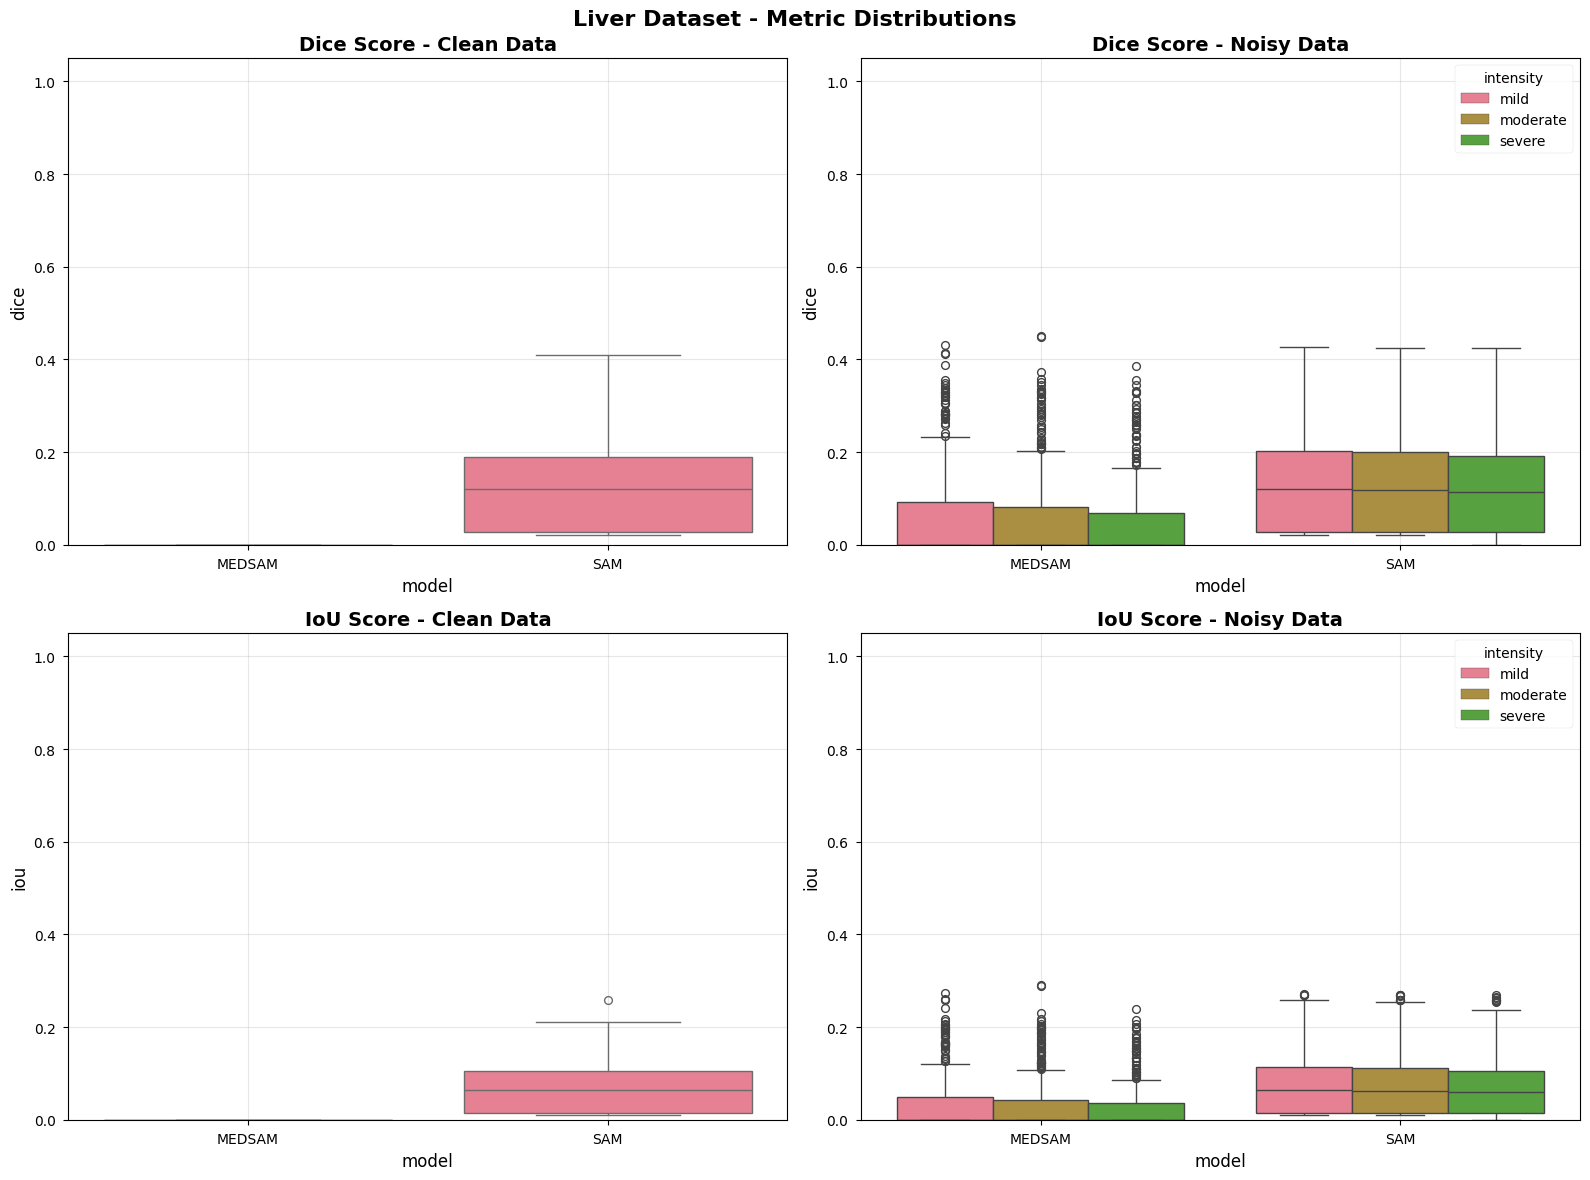

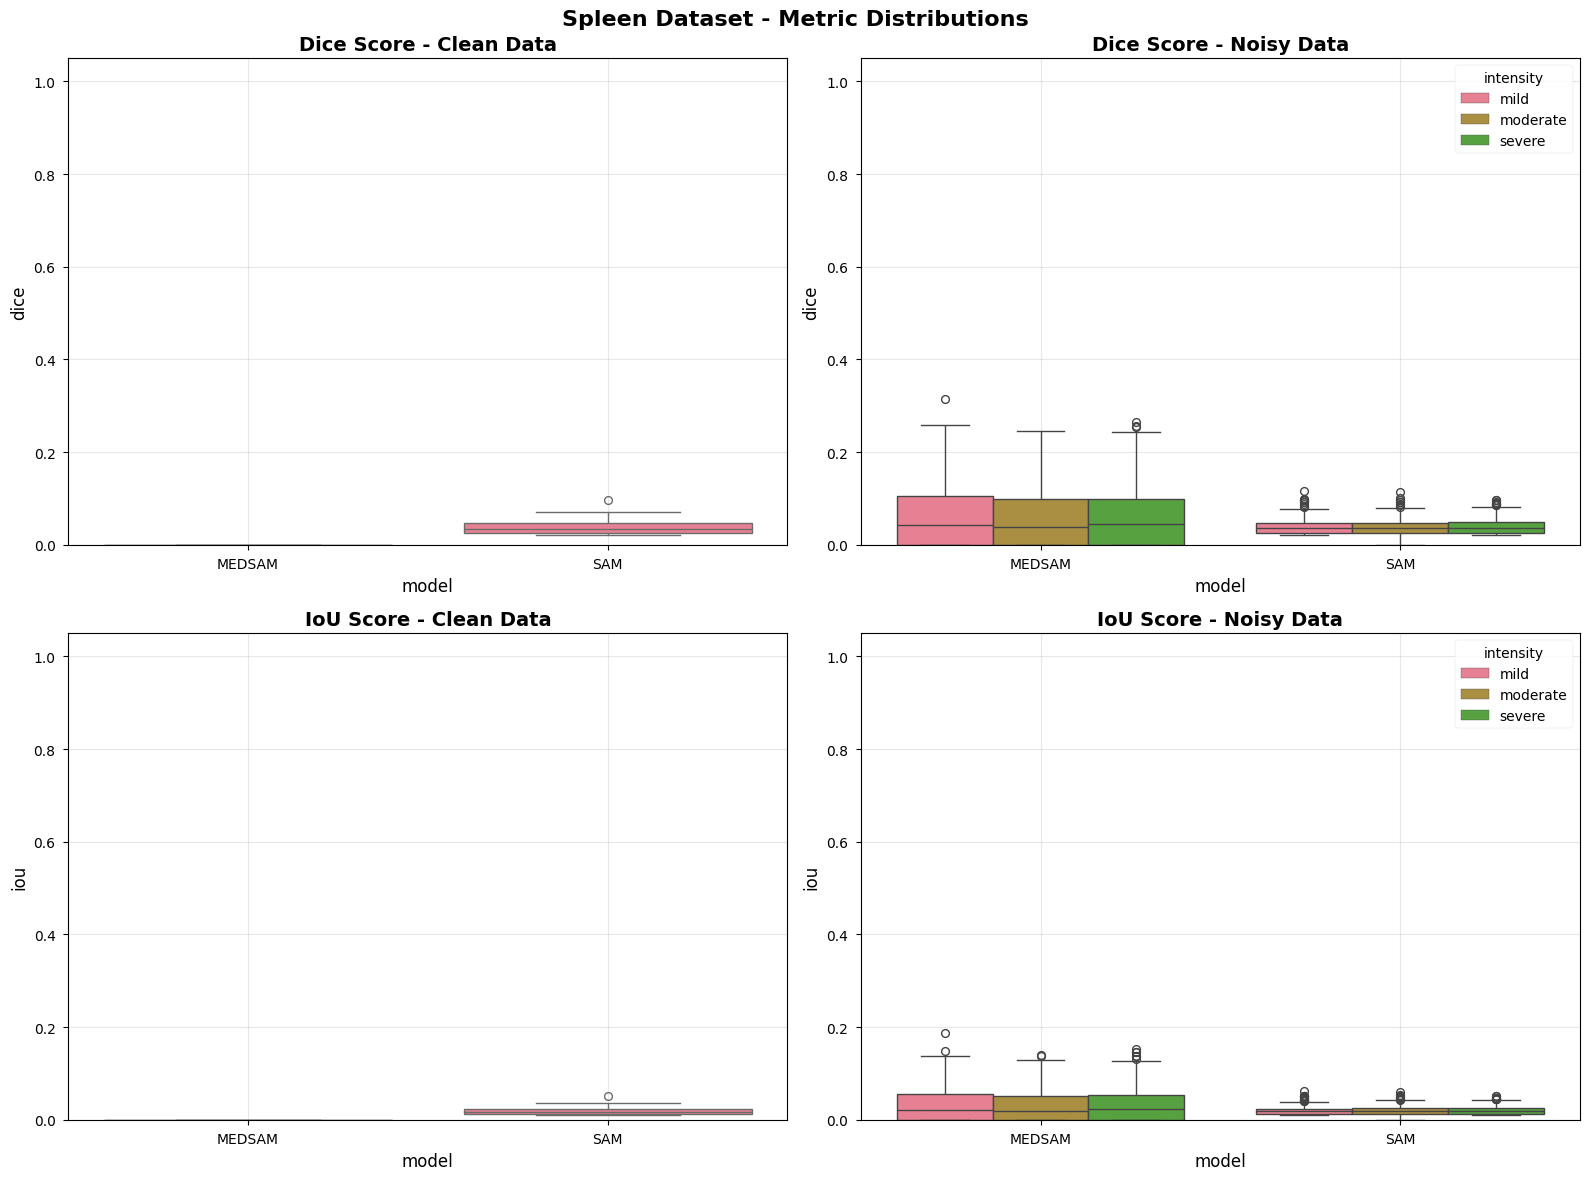

In [6]:
def plot_metric_boxplots(detailed_df, dataset_name):
    """
    Create box plots showing metric distributions.

    Args:
        detailed_df: Detailed metrics DataFrame
        dataset_name: Name of dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    clean_data = detailed_df[detailed_df['intensity'] == 'clean']
    noisy_data = detailed_df[detailed_df['intensity'] != 'clean']

    sns.boxplot(data=clean_data, x='model', y='dice', ax=axes[0, 0])
    axes[0, 0].set_title('Dice Score - Clean Data', fontweight='bold')
    axes[0, 0].set_ylim([0, 1.05])
    axes[0, 0].grid(True, alpha=0.3)

    sns.boxplot(data=noisy_data, x='model', y='dice', hue='intensity', ax=axes[0, 1])
    axes[0, 1].set_title('Dice Score - Noisy Data', fontweight='bold')
    axes[0, 1].set_ylim([0, 1.05])
    axes[0, 1].grid(True, alpha=0.3)

    sns.boxplot(data=clean_data, x='model', y='iou', ax=axes[1, 0])
    axes[1, 0].set_title('IoU Score - Clean Data', fontweight='bold')
    axes[1, 0].set_ylim([0, 1.05])
    axes[1, 0].grid(True, alpha=0.3)

    sns.boxplot(data=noisy_data, x='model', y='iou', hue='intensity', ax=axes[1, 1])
    axes[1, 1].set_title('IoU Score - Noisy Data', fontweight='bold')
    axes[1, 1].set_ylim([0, 1.05])
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f'{dataset_name.capitalize()} Dataset - Metric Distributions',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_metric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_metric_boxplots(liver_detailed, 'liver')
plot_metric_boxplots(spleen_detailed, 'spleen')

### 5. Noise Type Impact Visualization

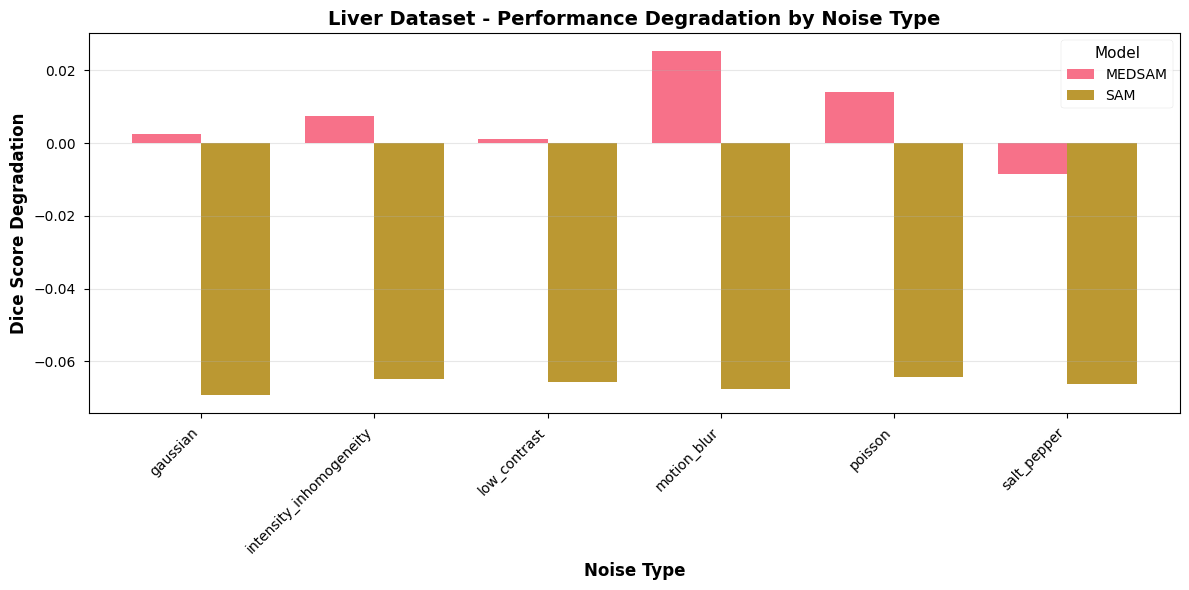

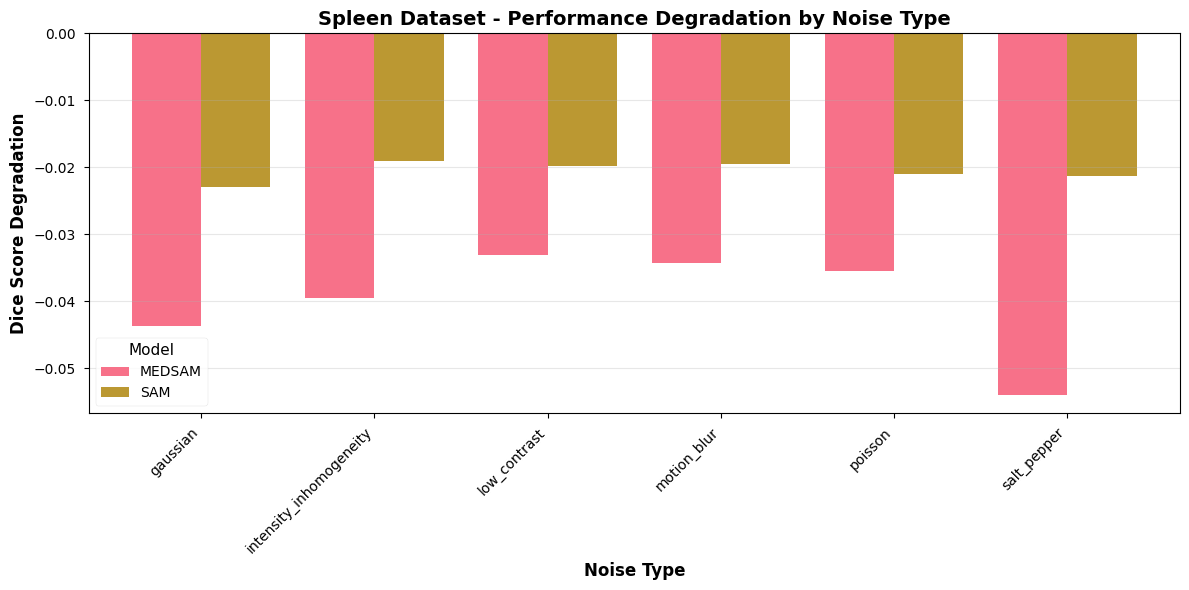

In [7]:
def plot_noise_impact(detailed_df, dataset_name):
    """
    Visualize impact of different noise types.

    Args:
        detailed_df: Detailed metrics DataFrame
        dataset_name: Name of dataset
    """
    clean_dice = detailed_df[detailed_df['intensity'] == 'clean']['dice'].mean()

    noise_impact = detailed_df[detailed_df['intensity'] != 'clean'].groupby(
        ['noise_type', 'model']
    )['dice'].mean().reset_index()

    noise_impact['degradation'] = clean_dice - noise_impact['dice']

    fig, ax = plt.subplots(figsize=(12, 6))

    noise_impact_pivot = noise_impact.pivot(index='noise_type',
                                            columns='model',
                                            values='degradation')

    noise_impact_pivot.plot(kind='bar', ax=ax, width=0.8)

    ax.set_xlabel('Noise Type', fontweight='bold')
    ax.set_ylabel('Dice Score Degradation', fontweight='bold')
    ax.set_title(f'{dataset_name.capitalize()} Dataset - Performance Degradation by Noise Type',
                fontweight='bold')
    ax.legend(title='Model', title_fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_noise_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_noise_impact(liver_detailed, 'liver')
plot_noise_impact(spleen_detailed, 'spleen')

### 6. Qualitative Failure Case Analysis

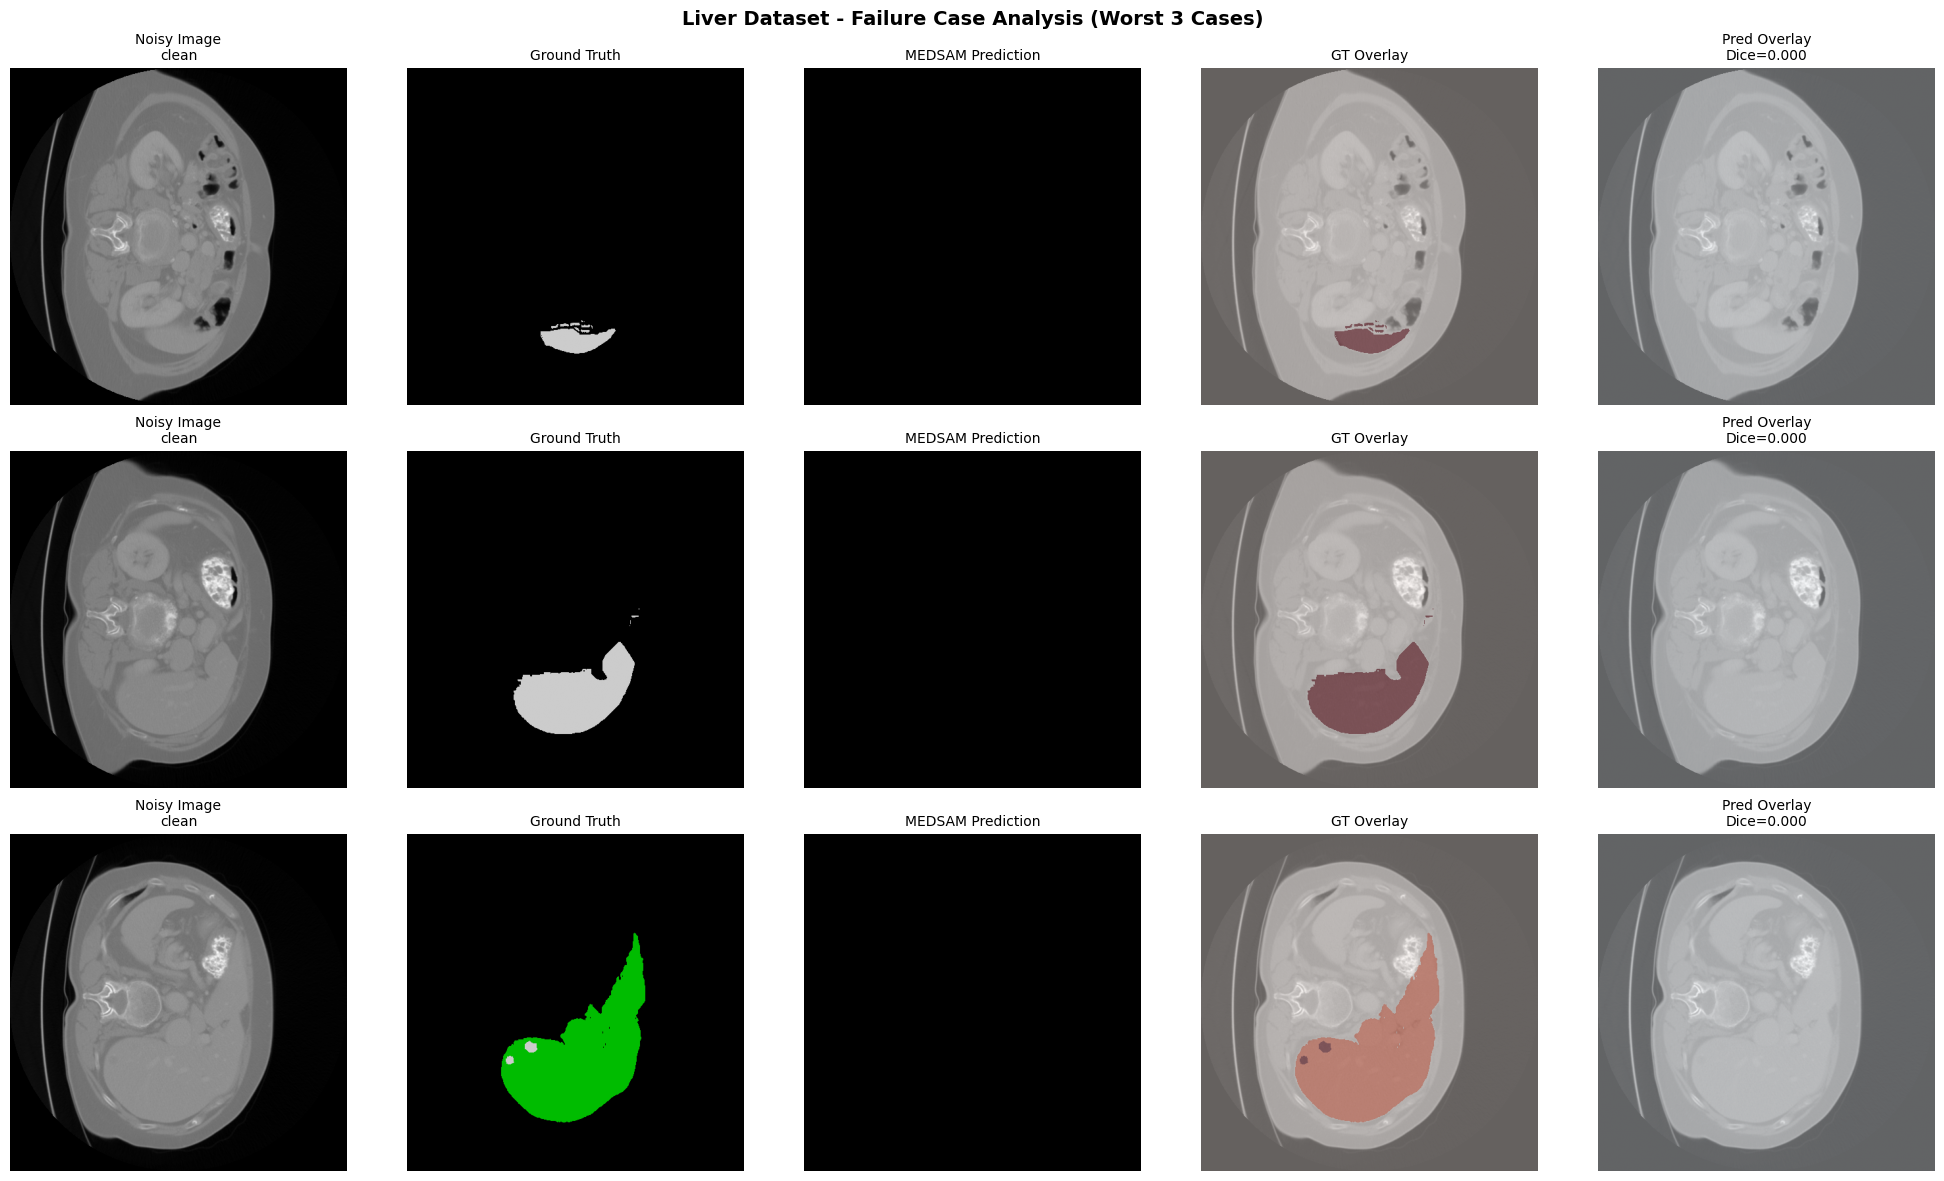

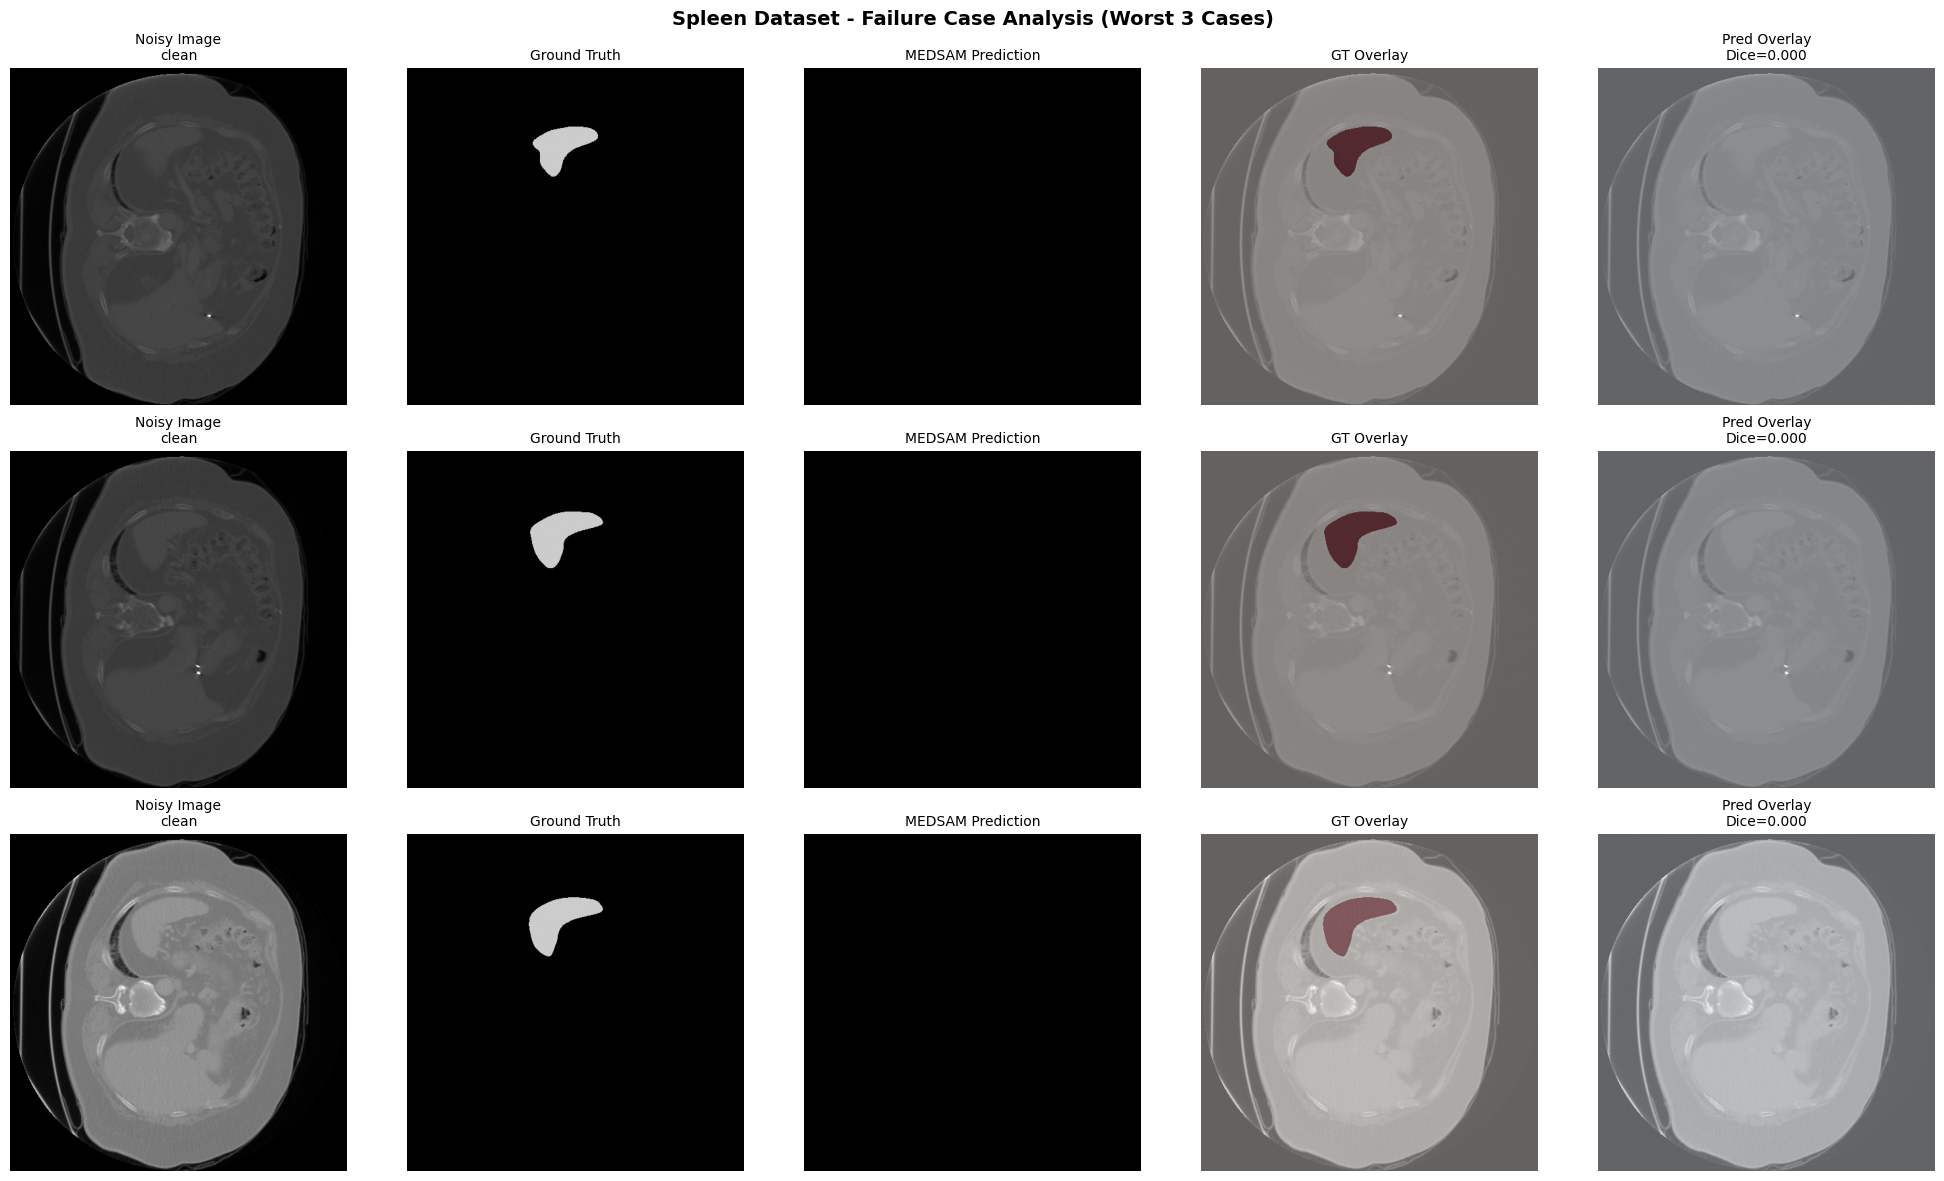

In [8]:
def visualize_failure_cases(dataset_name, num_cases=3):
    """
    Visualize worst-performing cases for failure analysis.

    Args:
        dataset_name: Name of dataset
        num_cases: Number of failure cases to show
    """
    detailed_df = pd.read_csv(RESULTS_PATH / f'{dataset_name}_detailed_metrics.csv')

    worst_cases = detailed_df.nsmallest(num_cases, 'dice')

    fig, axes = plt.subplots(num_cases, 5, figsize=(20, 4*num_cases))

    for idx, (_, row) in enumerate(worst_cases.iterrows()):
        variant = row['variant']
        img_idx = row['image_idx']
        model = row['model'].lower()

        noisy_img = np.load(NOISY_DATA_PATH / dataset_name / variant / 'images.npy')[img_idx]
        gt = np.load(NOISY_DATA_PATH / dataset_name / variant / 'labels.npy')[img_idx]
        pred = np.load(PREDICTIONS_PATH / dataset_name / variant / model / 'predictions.npy')[img_idx]

        axes[idx, 0].imshow(noisy_img, cmap='gray')
        axes[idx, 0].set_title(f'Noisy Image\n{variant}', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(gt, cmap='nipy_spectral')
        axes[idx, 1].set_title('Ground Truth', fontsize=10)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred, cmap='nipy_spectral')
        axes[idx, 2].set_title(f'{model.upper()} Prediction', fontsize=10)
        axes[idx, 2].axis('off')

        axes[idx, 3].imshow(noisy_img, cmap='gray')
        axes[idx, 3].imshow(gt, cmap='Reds', alpha=0.4)
        axes[idx, 3].set_title('GT Overlay', fontsize=10)
        axes[idx, 3].axis('off')

        axes[idx, 4].imshow(noisy_img, cmap='gray')
        axes[idx, 4].imshow(pred, cmap='Blues', alpha=0.4)
        axes[idx, 4].set_title(f'Pred Overlay\nDice={row["dice"]:.3f}', fontsize=10)
        axes[idx, 4].axis('off')

    plt.suptitle(f'{dataset_name.capitalize()} Dataset - Failure Case Analysis (Worst {num_cases} Cases)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_failure_cases.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_failure_cases('liver', num_cases=3)
visualize_failure_cases('spleen', num_cases=3)

### 7. Best Case Visualization

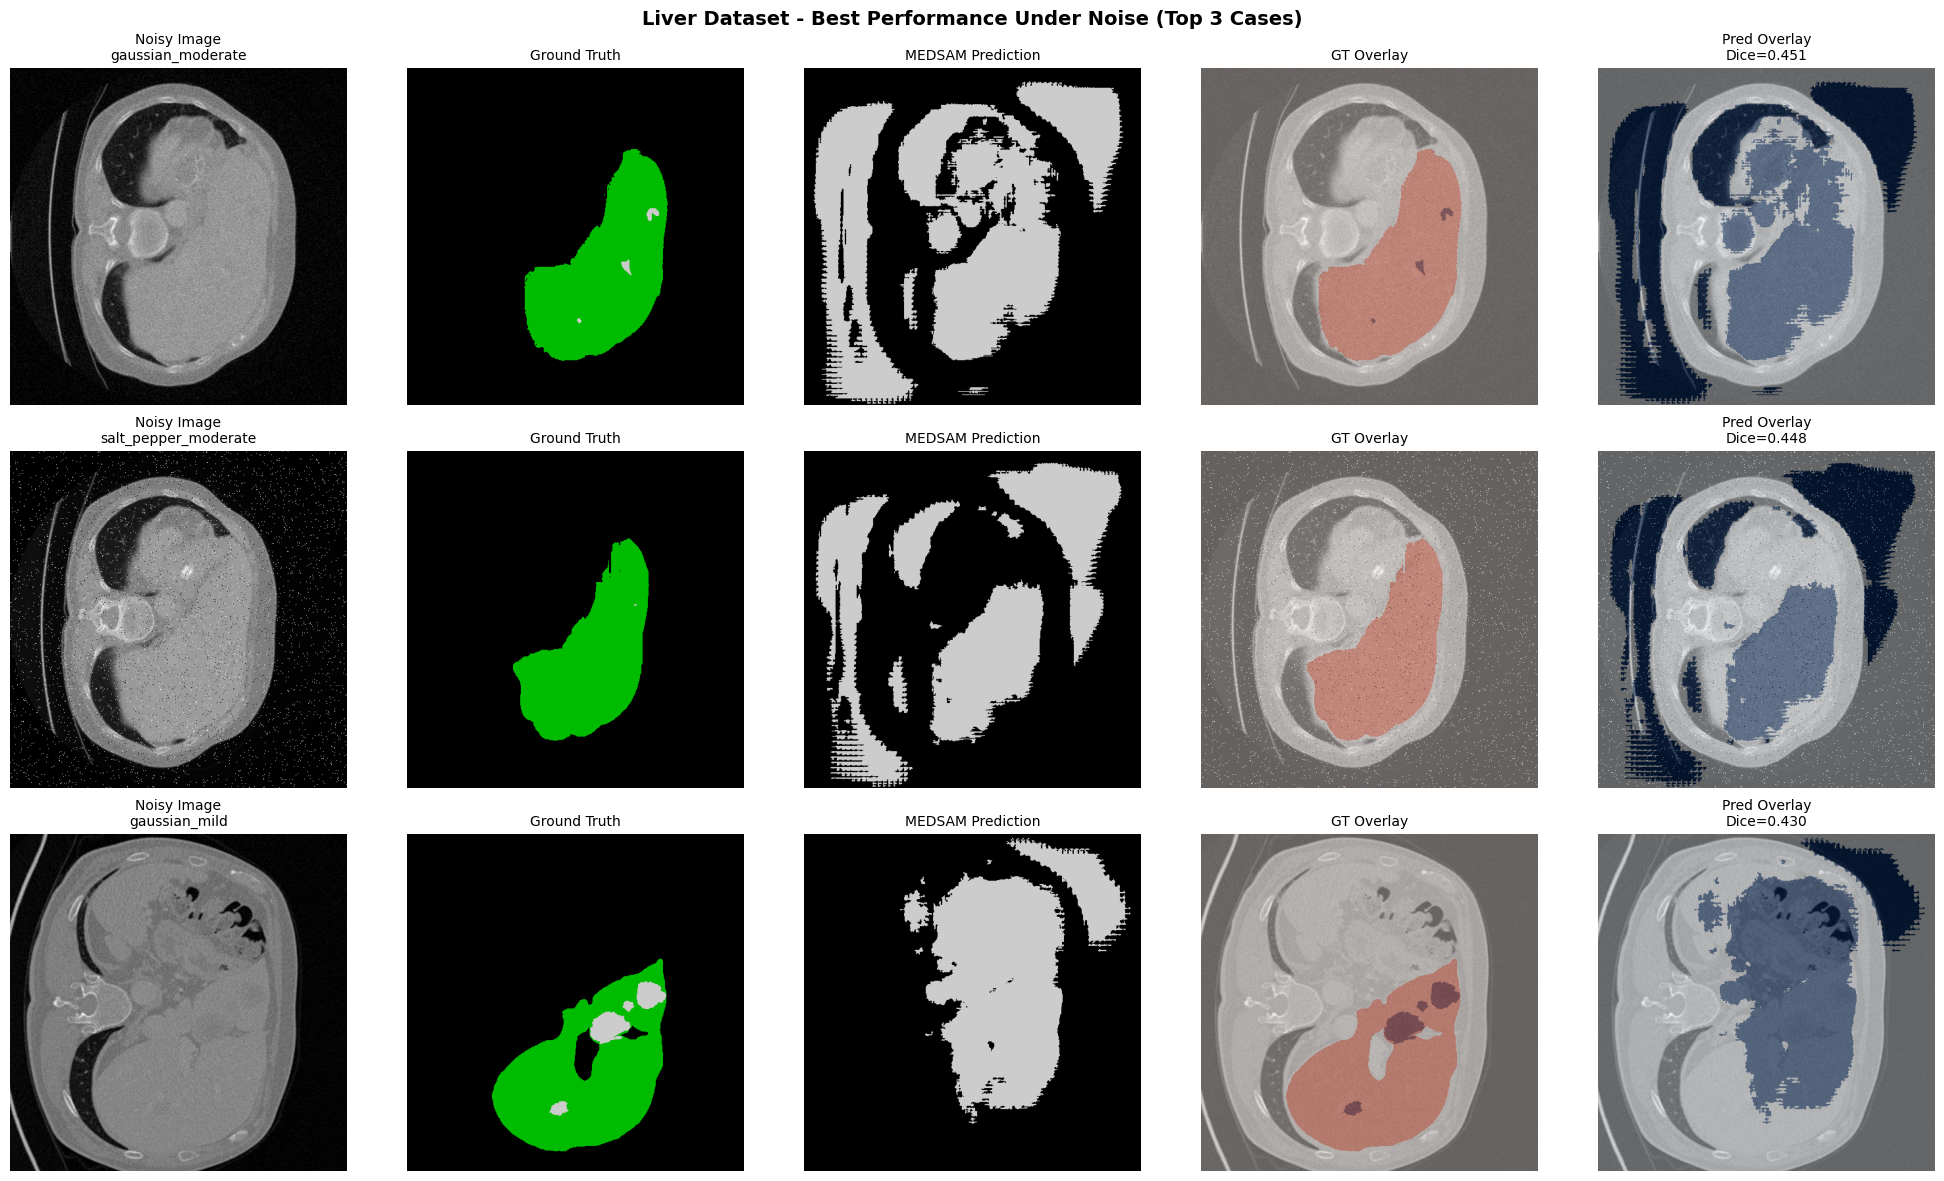

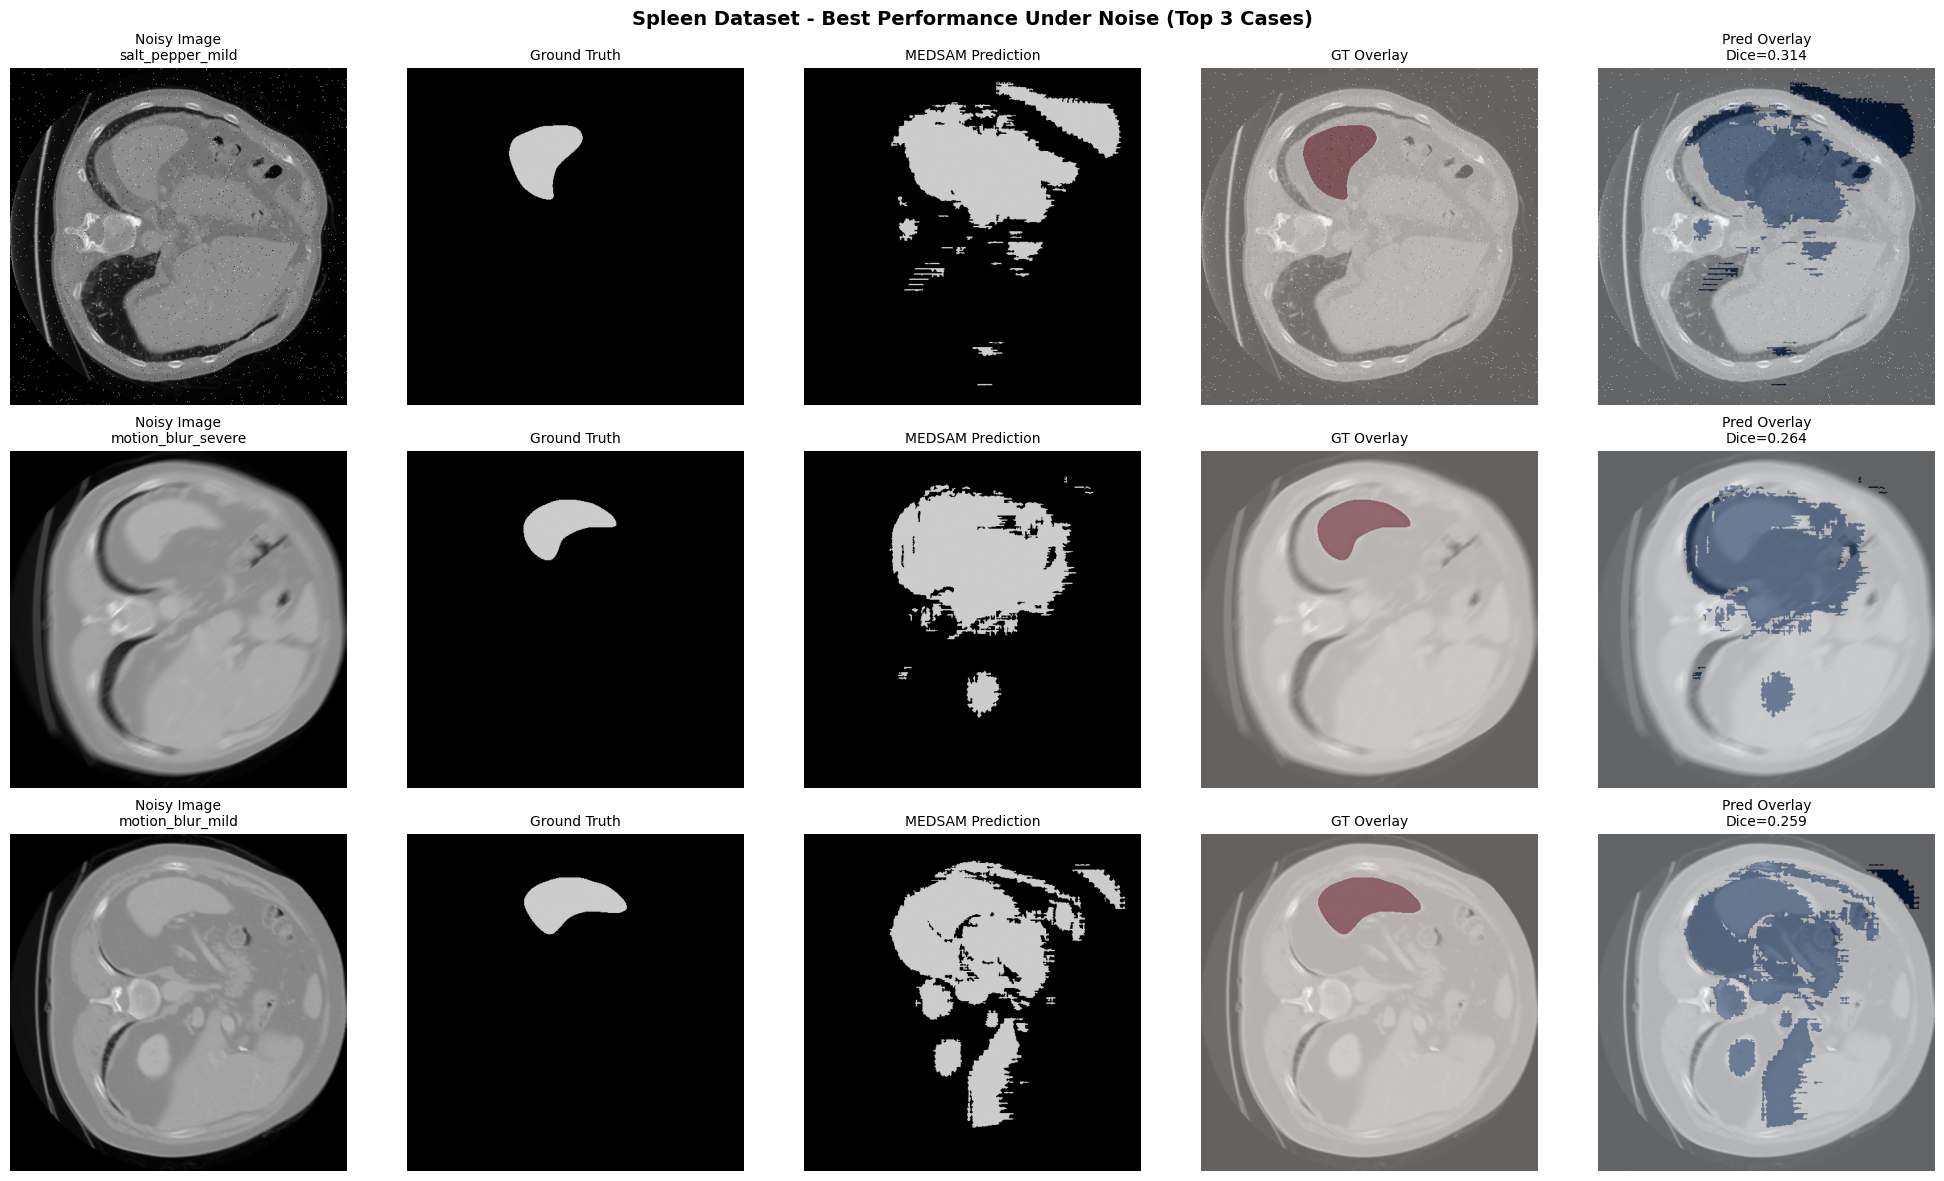

In [9]:
def visualize_best_cases(dataset_name, num_cases=3):
    """
    Visualize best-performing cases.

    Args:
        dataset_name: Name of dataset
        num_cases: Number of best cases to show
    """
    detailed_df = pd.read_csv(RESULTS_PATH / f'{dataset_name}_detailed_metrics.csv')
    noisy_df = detailed_df[detailed_df['intensity'] != 'clean']

    best_cases = noisy_df.nlargest(num_cases, 'dice')

    fig, axes = plt.subplots(num_cases, 5, figsize=(20, 4*num_cases))

    for idx, (_, row) in enumerate(best_cases.iterrows()):
        variant = row['variant']
        img_idx = row['image_idx']
        model = row['model'].lower()

        noisy_img = np.load(NOISY_DATA_PATH / dataset_name / variant / 'images.npy')[img_idx]
        gt = np.load(NOISY_DATA_PATH / dataset_name / variant / 'labels.npy')[img_idx]
        pred = np.load(PREDICTIONS_PATH / dataset_name / variant / model / 'predictions.npy')[img_idx]

        axes[idx, 0].imshow(noisy_img, cmap='gray')
        axes[idx, 0].set_title(f'Noisy Image\n{variant}', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(gt, cmap='nipy_spectral')
        axes[idx, 1].set_title('Ground Truth', fontsize=10)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred, cmap='nipy_spectral')
        axes[idx, 2].set_title(f'{model.upper()} Prediction', fontsize=10)
        axes[idx, 2].axis('off')

        axes[idx, 3].imshow(noisy_img, cmap='gray')
        axes[idx, 3].imshow(gt, cmap='Reds', alpha=0.4)
        axes[idx, 3].set_title('GT Overlay', fontsize=10)
        axes[idx, 3].axis('off')

        axes[idx, 4].imshow(noisy_img, cmap='gray')
        axes[idx, 4].imshow(pred, cmap='Blues', alpha=0.4)
        axes[idx, 4].set_title(f'Pred Overlay\nDice={row["dice"]:.3f}', fontsize=10)
        axes[idx, 4].axis('off')

    plt.suptitle(f'{dataset_name.capitalize()} Dataset - Best Performance Under Noise (Top {num_cases} Cases)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'{dataset_name}_best_cases.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_best_cases('liver', num_cases=3)
visualize_best_cases('spleen', num_cases=3)

### 8. Statistical Significance Testing

In [10]:
def statistical_significance_tests(detailed_df, dataset_name):
    """
    Perform statistical significance tests between models.

    Args:
        detailed_df: Detailed metrics DataFrame
        dataset_name: Name of dataset

    Returns:
        DataFrame with test results
    """
    models = detailed_df['model'].unique()
    results = []

    for variant in detailed_df['variant'].unique():
        variant_data = detailed_df[detailed_df['variant'] == variant]

        if len(models) == 2:
            model1_dice = variant_data[variant_data['model'] == models[0]]['dice'].values
            model2_dice = variant_data[variant_data['model'] == models[1]]['dice'].values

            if len(model1_dice) > 0 and len(model2_dice) > 0:
                t_stat, p_value = stats.ttest_ind(model1_dice, model2_dice)

                results.append({
                    'variant': variant,
                    'comparison': f"{models[0]} vs {models[1]}",
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'significant': 'Yes' if p_value < 0.05 else 'No',
                    'mean_diff': model1_dice.mean() - model2_dice.mean()
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv(RESULTS_PATH / f'{dataset_name}_statistical_tests.csv', index=False)

    return results_df

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

print("\nLiver Dataset:")
liver_stats = statistical_significance_tests(liver_detailed, 'liver')
print(liver_stats.head(10).to_string(index=False))

print("\nSpleen Dataset:")
spleen_stats = statistical_significance_tests(spleen_detailed, 'spleen')
print(spleen_stats.head(10).to_string(index=False))

significant_liver = liver_stats[liver_stats['significant'] == 'Yes']
significant_spleen = spleen_stats[spleen_stats['significant'] == 'Yes']

print(f"\nLiver: {len(significant_liver)}/{len(liver_stats)} comparisons statistically significant (p<0.05)")
print(f"Spleen: {len(significant_spleen)}/{len(spleen_stats)} comparisons statistically significant (p<0.05)")


STATISTICAL SIGNIFICANCE TESTING

Liver Dataset:
                         variant    comparison  t_statistic      p_value significant  mean_diff
                           clean MEDSAM vs SAM    -8.609389 1.249524e-13         Yes  -0.131258
                   gaussian_mild MEDSAM vs SAM    -3.177613 1.986761e-03         Yes  -0.070191
               gaussian_moderate MEDSAM vs SAM    -2.268440 2.549632e-02         Yes  -0.054017
                 gaussian_severe MEDSAM vs SAM    -4.829397 5.052184e-06         Yes  -0.091767
    intensity_inhomogeneity_mild MEDSAM vs SAM    -3.198768 1.859472e-03         Yes  -0.071843
intensity_inhomogeneity_moderate MEDSAM vs SAM    -3.950806 1.469397e-04         Yes  -0.080186
  intensity_inhomogeneity_severe MEDSAM vs SAM    -3.031753 3.110833e-03         Yes  -0.065004
               low_contrast_mild MEDSAM vs SAM    -3.180514 1.968841e-03         Yes  -0.066677
           low_contrast_moderate MEDSAM vs SAM    -3.179985 1.972096e-03         Yes  

### 9. Comprehensive Summary Figure

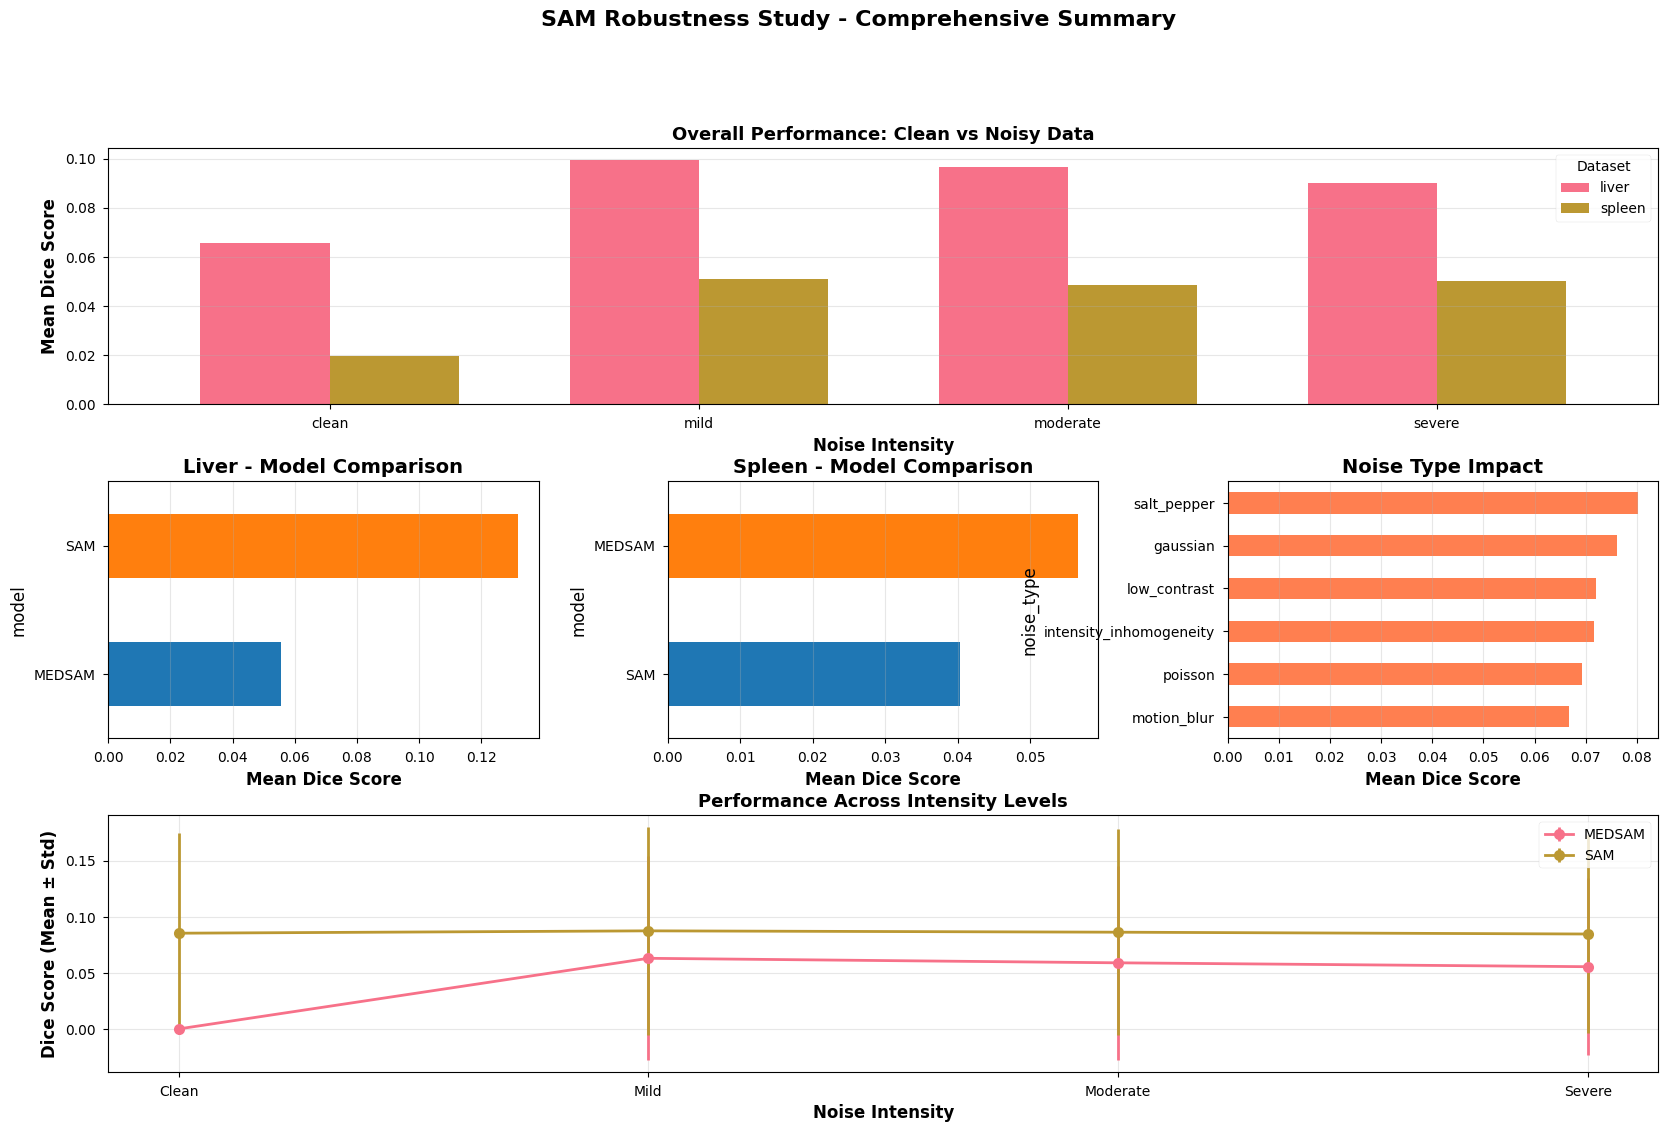

In [11]:
def create_comprehensive_summary():
    """
    Create comprehensive summary figure combining multiple visualizations.
    """
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    combined_df = pd.concat([liver_detailed, spleen_detailed])
    clean_vs_noisy = combined_df.groupby(['dataset', 'intensity']).agg({
        'dice': 'mean'
    }).reset_index()
    clean_vs_noisy_pivot = clean_vs_noisy.pivot(index='intensity',
                                                 columns='dataset',
                                                 values='dice')
    clean_vs_noisy_pivot.plot(kind='bar', ax=ax1, width=0.7)
    ax1.set_title('Overall Performance: Clean vs Noisy Data', fontweight='bold', fontsize=13)
    ax1.set_ylabel('Mean Dice Score', fontweight='bold')
    ax1.set_xlabel('Noise Intensity', fontweight='bold')
    ax1.legend(title='Dataset', title_fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

    ax2 = fig.add_subplot(gs[1, 0])
    liver_model_comp = liver_detailed.groupby('model')['dice'].mean().sort_values()
    liver_model_comp.plot(kind='barh', ax=ax2, color=['#1f77b4', '#ff7f0e'])
    ax2.set_title('Liver - Model Comparison', fontweight='bold')
    ax2.set_xlabel('Mean Dice Score', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    ax3 = fig.add_subplot(gs[1, 1])
    spleen_model_comp = spleen_detailed.groupby('model')['dice'].mean().sort_values()
    spleen_model_comp.plot(kind='barh', ax=ax3, color=['#1f77b4', '#ff7f0e'])
    ax3.set_title('Spleen - Model Comparison', fontweight='bold')
    ax3.set_xlabel('Mean Dice Score', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')

    ax4 = fig.add_subplot(gs[1, 2])
    combined_noise = combined_df[combined_df['intensity'] != 'clean'].groupby(
        'noise_type'
    )['dice'].mean().sort_values()
    combined_noise.plot(kind='barh', ax=ax4, color='coral')
    ax4.set_title('Noise Type Impact', fontweight='bold')
    ax4.set_xlabel('Mean Dice Score', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

    ax5 = fig.add_subplot(gs[2, :])
    intensity_perf = combined_df.groupby(['intensity', 'model']).agg({
        'dice': ['mean', 'std']
    }).reset_index()
    intensity_perf.columns = ['intensity', 'model', 'dice_mean', 'dice_std']

    for model in intensity_perf['model'].unique():
        model_data = intensity_perf[intensity_perf['model'] == model]
        ax5.errorbar(range(len(model_data)), model_data['dice_mean'],
                    yerr=model_data['dice_std'], marker='o',
                    label=model, capsize=5, linewidth=2, markersize=8)

    ax5.set_xticks(range(len(model_data)))
    ax5.set_xticklabels([i.capitalize() for i in model_data['intensity']])
    ax5.set_xlabel('Noise Intensity', fontweight='bold')
    ax5.set_ylabel('Dice Score (Mean ± Std)', fontweight='bold')
    ax5.set_title('Performance Across Intensity Levels', fontweight='bold', fontsize=13)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    plt.suptitle('SAM Robustness Study - Comprehensive Summary',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(FIGURES_PATH / 'comprehensive_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

create_comprehensive_summary()

### 10. Final Summary Report

In [12]:
print("\n" + "="*80)
print("VISUALIZATION AND ANALYSIS COMPLETE")
print("="*80)

figures_created = [
    'liver_dice_degradation.png',
    'liver_iou_degradation.png',
    'spleen_dice_degradation.png',
    'spleen_iou_degradation.png',
    'liver_dice_heatmap.png',
    'spleen_dice_heatmap.png',
    'liver_metric_distributions.png',
    'spleen_metric_distributions.png',
    'liver_noise_impact.png',
    'spleen_noise_impact.png',
    'liver_failure_cases.png',
    'spleen_failure_cases.png',
    'liver_best_cases.png',
    'spleen_best_cases.png',
    'comprehensive_summary.png'
]

print("\nFigures Created:")
for fig in figures_created:
    print(f"  - {fig}")

print(f"\nAll figures saved to: {FIGURES_PATH}")
print(f"Statistical test results saved to: {RESULTS_PATH}")

print("\n" + "="*80)
print("ALL NOTEBOOKS COMPLETE - READY FOR CVPR WORKSHOP SUBMISSION")
print("="*80)


VISUALIZATION AND ANALYSIS COMPLETE

Figures Created:
  - liver_dice_degradation.png
  - liver_iou_degradation.png
  - spleen_dice_degradation.png
  - spleen_iou_degradation.png
  - liver_dice_heatmap.png
  - spleen_dice_heatmap.png
  - liver_metric_distributions.png
  - spleen_metric_distributions.png
  - liver_noise_impact.png
  - spleen_noise_impact.png
  - liver_failure_cases.png
  - spleen_failure_cases.png
  - liver_best_cases.png
  - spleen_best_cases.png
  - comprehensive_summary.png

All figures saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/figures
Statistical test results saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/results

ALL NOTEBOOKS COMPLETE - READY FOR CVPR WORKSHOP SUBMISSION
